In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras

In [210]:
# loading the data
data = pd.read_csv('../../datasets/nyu_data/data/nyu2_test_mse_brisque.csv')

# normal image paths
normal_image_paths = data['0'].values

# replacing 'nyu2_test' with 'nyu2_test_blur_15_15' in paths to get the blurred image paths
blurred_image_paths = [path.replace('nyu2_test', 'nyu2_test_blur_15_15') for path in normal_image_paths]

# replacing 'nyu2_test' with 'nyu2_test_noise_0_4' in paths to get the noisy image paths
noisy_image_paths = [path.replace('nyu2_test', 'nyu2_test_noise_0_4') for path in normal_image_paths]

In [211]:
# normal image scores
normal_image_scores = data['mse'].values

# blurred image scores
blurred_image_scores  = data['mse_blur_15_15'].values

# noisy image scores
noisy_image_scores = data['mse_noise_0_4'].values

In [212]:
image_paths = np.concatenate((normal_image_paths, blurred_image_paths, noisy_image_paths), axis=0)
mse_scores = np.concatenate((normal_image_scores, blurred_image_scores, noisy_image_scores), axis=0)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, mse_scores, test_size=0.2, random_state=42)

In [214]:
def load_and_preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Adjust if not JPEG
    image = tf.image.resize(image, [224, 224])  # Set desired input size
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image

In [215]:
# **2. Dataset Creation**

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.map(lambda x, y: (load_and_preprocess(x), y)).batch(32)
test_ds = test_ds.map(lambda x, y: (load_and_preprocess(x), y)).batch(32)


In [216]:
# **3. Model Definition (Expanded)**
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
base_model.trainable = True  # Optionally freeze base layers

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.Flatten()(x)

# Stacked Dense Layers
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = models.Model(inputs, outputs)

# model summary
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_17 (Flatten)        (None, 25088)             0         
                                                                 
 dense_63 (Dense)            (None, 512)               12845568  
                                                                 
 dense_64 (Dense)            (None, 256)               131328    
                                                                 
 dense_65 (Dense)            (None, 128)               32896     
                                                                 
 dense_66 (Dense)            (None, 64)                825

In [217]:
# **4. Compilation** along with the optimizer, loss function and metrics and early stopping
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

In [218]:
# **5. Training with Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [221]:
# **5. Training**
model.fit(train_ds, epochs=50, validation_data=test_ds,callbacks=[early_stopping])

Epoch 1/50
50/50 [==============================] - 10s 114ms/step - loss: 39.8789 - mae: 1.9276 - mse: 39.8789 - val_loss: 0.0046 - val_mae: 0.0546 - val_mse: 0.0046
Epoch 2/50
50/50 [==============================] - 5s 106ms/step - loss: 0.0048 - mae: 0.0543 - mse: 0.0048 - val_loss: 0.0049 - val_mae: 0.0513 - val_mse: 0.0049
Epoch 3/50
50/50 [==============================] - 5s 103ms/step - loss: 0.0046 - mae: 0.0534 - mse: 0.0046 - val_loss: 0.0045 - val_mae: 0.0495 - val_mse: 0.0045
Epoch 4/50
50/50 [==============================] - 5s 100ms/step - loss: 0.0045 - mae: 0.0523 - mse: 0.0045 - val_loss: 0.0048 - val_mae: 0.0524 - val_mse: 0.0048
Epoch 5/50
50/50 [==============================] - 5s 101ms/step - loss: 0.0046 - mae: 0.0534 - mse: 0.0046 - val_loss: 0.0046 - val_mae: 0.0506 - val_mse: 0.0046
Epoch 6/50
50/50 [==============================] - 5s 104ms/step - loss: 0.0045 - mae: 0.0521 - mse: 0.0045 - val_loss: 0.0053 - val_mae: 0.0556 - val_mse: 0.0053
Epoch 7/50
50

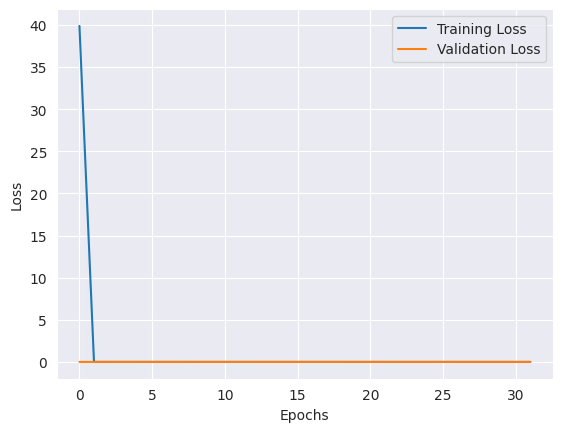

In [222]:
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [223]:
# getting the predicted values for the test set in an array
y_pred = model.predict(test_ds)

13/13 [==============================] - 1s 25ms/step


In [224]:
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred)**2)
print(f'MAE: {mae}, MSE: {mse}')

MAE: 0.05616147414252121, MSE: 0.004902822542802224


In [225]:
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(y_test, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')

Pearson Correlation: 0.2837930790760676


In [226]:
# putting pred and actual values in a dataframe
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})

In [227]:
df.head()

,Actual,Predicted
0,0.129502,0.098842
1,0.090360,0.112829
2,0.118630,0.120562
3,0.040979,0.132990
4,0.093389,0.114319


In [239]:
# Model Definition
model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3 (Optional, add more if desired)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))  # Prevent overfitting
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))  # Output layer for MSE regression

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Epoch 1/50
50/50 [==============================] - 5s 33ms/step - loss: 10449.7656 - mae: 25.0526 - mse: 10449.7656 - val_loss: 0.0108 - val_mae: 0.0804 - val_mse: 0.0108
Epoch 2/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0136 - mae: 0.0876 - mse: 0.0136 - val_loss: 0.0079 - val_mae: 0.0696 - val_mse: 0.0079
Epoch 3/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0111 - mae: 0.0777 - mse: 0.0111 - val_loss: 0.0065 - val_mae: 0.0635 - val_mse: 0.0065
Epoch 4/50
50/50 [==============================] - 1s 19ms/step - loss: 0.0082 - mae: 0.0664 - mse: 0.0082 - val_loss: 0.0063 - val_mae: 0.0616 - val_mse: 0.0063
Epoch 5/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0635 - mse: 0.0073 - val_loss: 0.0057 - val_mae: 0.0574 - val_mse: 0.0057
Epoch 6/50
50/50 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0591 - mse: 0.0067 - val_loss: 0.0056 - val_mae: 0.0564 - val_mse: 0.0056
Epoch 7/50
50

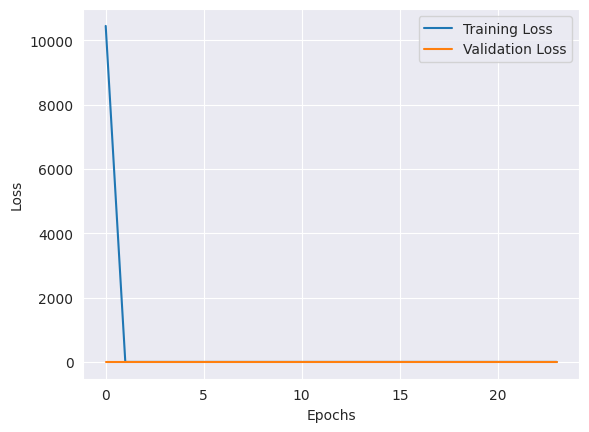

13/13 [==============================] - 0s 9ms/step
MAE: 0.061929181942413036, MSE: 0.006583668274726261
Pearson Correlation: 0.43671138555862843


In [240]:
# **4. Compilation** along with the optimizer, loss function and metrics and early stopping
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
# **5. Training with Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# **5. Training**
model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# getting the predicted values for the test set in an array
y_pred = model.predict(test_ds)
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred) ** 2)
print(f'MAE: {mae}, MSE: {mse}')
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(y_test, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')

In [241]:
# Model Definition
model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 4 (Optional)
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))  # Increased dropout for stronger regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1))  # Output layer for MSE regression

# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 256)     

Epoch 1/50
50/50 [==============================] - 6s 41ms/step - loss: 68211.0469 - mae: 38.6004 - mse: 68211.0469 - val_loss: 0.0146 - val_mae: 0.0940 - val_mse: 0.0146
Epoch 2/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0132 - mae: 0.0880 - mse: 0.0132 - val_loss: 0.0070 - val_mae: 0.0635 - val_mse: 0.0070
Epoch 3/50
50/50 [==============================] - 1s 27ms/step - loss: 0.0070 - mae: 0.0620 - mse: 0.0070 - val_loss: 0.0054 - val_mae: 0.0555 - val_mse: 0.0054
Epoch 4/50
50/50 [==============================] - 1s 27ms/step - loss: 0.0054 - mae: 0.0535 - mse: 0.0054 - val_loss: 0.0048 - val_mae: 0.0505 - val_mse: 0.0048
Epoch 5/50
50/50 [==============================] - 1s 28ms/step - loss: 0.0045 - mae: 0.0497 - mse: 0.0045 - val_loss: 0.0046 - val_mae: 0.0493 - val_mse: 0.0046
Epoch 6/50
50/50 [==============================] - 1s 27ms/step - loss: 0.0041 - mae: 0.0458 - mse: 0.0041 - val_loss: 0.0045 - val_mae: 0.0483 - val_mse: 0.0045
Epoch 7/50
50

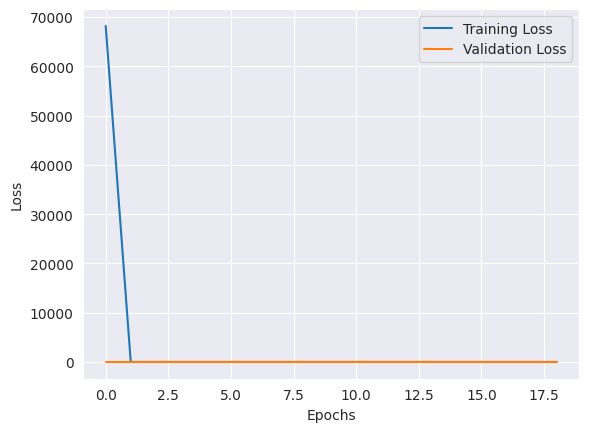

13/13 [==============================] - 0s 11ms/step
MAE: 0.05472190285194493, MSE: 0.005281496308094769
Pearson Correlation: 0.24847667193462217


In [242]:
# **4. Compilation** along with the optimizer, loss function and metrics and early stopping
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
# **5. Training with Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# **5. Training**
model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# getting the predicted values for the test set in an array
y_pred = model.predict(test_ds)
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred) ** 2)
print(f'MAE: {mae}, MSE: {mse}')
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(y_test, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')

In [261]:
# Model Definition
model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3 (Optional, add more if desired)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))  # Prevent overfitting
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))  # Output layer for MSE regression
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)
# Model Summary
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 5

In [266]:
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Epoch 1/50
50/50 [==============================] - 4s 34ms/step - loss: 19662.6973 - mae: 28.1841 - mse: 19662.6973 - val_loss: 0.0097 - val_mae: 0.0782 - val_mse: 0.0097
Epoch 2/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0116 - mae: 0.0833 - mse: 0.0116 - val_loss: 0.0076 - val_mae: 0.0660 - val_mse: 0.0076
Epoch 3/50
50/50 [==============================] - 1s 26ms/step - loss: 0.0092 - mae: 0.0707 - mse: 0.0092 - val_loss: 0.0061 - val_mae: 0.0575 - val_mse: 0.0061
Epoch 4/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0613 - mse: 0.0071 - val_loss: 0.0047 - val_mae: 0.0518 - val_mse: 0.0047
Epoch 5/50
50/50 [==============================] - 1s 25ms/step - loss: 0.0060 - mae: 0.0572 - mse: 0.0060 - val_loss: 0.0043 - val_mae: 0.0504 - val_mse: 0.0043
Epoch 6/50
50/50 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0568 - mse: 0.0058 - val_loss: 0.0041 - val_mae: 0.0511 - val_mse: 0.0041
Epoch 7/50
50

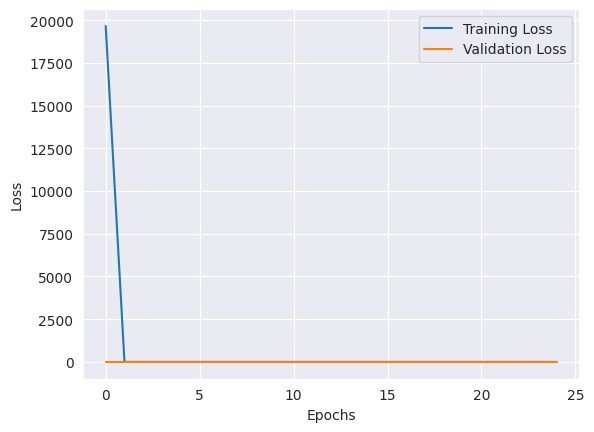

13/13 [==============================] - 0s 10ms/step
MAE: 0.05487363100886068, MSE: 0.005030041779022761
Pearson Correlation: 0.32578858292375706


In [252]:
# **4. Compilation** along with the optimizer, loss function and metrics and early stopping
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
# **5. Training with Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# **5. Training**
model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# getting the predicted values for the test set in an array
y_pred = model.predict(test_ds)
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred) ** 2)
print(f'MAE: {mae}, MSE: {mse}')
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(y_test, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')

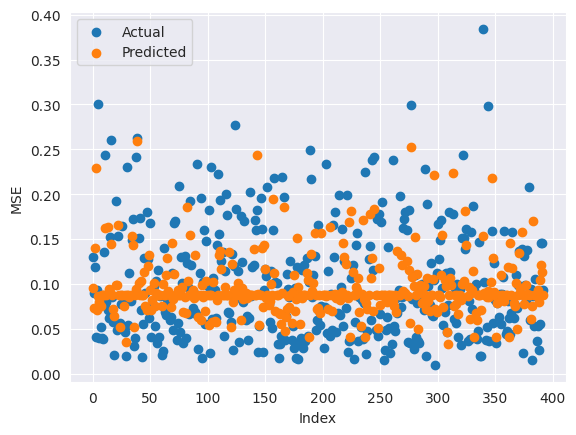

In [253]:
# getting scatter plot of actual vs predicted values with x axis being just the index and y axis being the actual and predicted values
plt.scatter(range(len(y_test)), y_test, label='Actual')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
# plotting a line plot of the actual and predicted values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [249]:
# Model Definition
model = models.Sequential()

# Convolutional Block 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Block 3 (Optional, add more if desired)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))  # Prevent overfitting
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1))  # Output layer for MSE regression

# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 128)     

Epoch 1/50
50/50 [==============================] - 5s 48ms/step - loss: 73289.4062 - mae: 48.3200 - mse: 73289.4062 - val_loss: 0.1424 - val_mae: 0.3135 - val_mse: 0.1424
Epoch 2/50
50/50 [==============================] - 2s 33ms/step - loss: 0.5104 - mae: 0.4990 - mse: 0.5104 - val_loss: 0.0100 - val_mae: 0.0804 - val_mse: 0.0100
Epoch 3/50
50/50 [==============================] - 1s 22ms/step - loss: 0.1181 - mae: 0.2382 - mse: 0.1181 - val_loss: 0.0125 - val_mae: 0.0845 - val_mse: 0.0125
Epoch 4/50
50/50 [==============================] - 2s 34ms/step - loss: 0.0702 - mae: 0.1886 - mse: 0.0702 - val_loss: 0.0078 - val_mae: 0.0677 - val_mse: 0.0078
Epoch 5/50
50/50 [==============================] - 2s 33ms/step - loss: 0.0536 - mae: 0.1662 - mse: 0.0536 - val_loss: 0.0070 - val_mae: 0.0651 - val_mse: 0.0070
Epoch 6/50
50/50 [==============================] - 1s 22ms/step - loss: 0.0283 - mae: 0.1255 - mse: 0.0283 - val_loss: 0.0080 - val_mae: 0.0692 - val_mse: 0.0080
Epoch 7/50
50

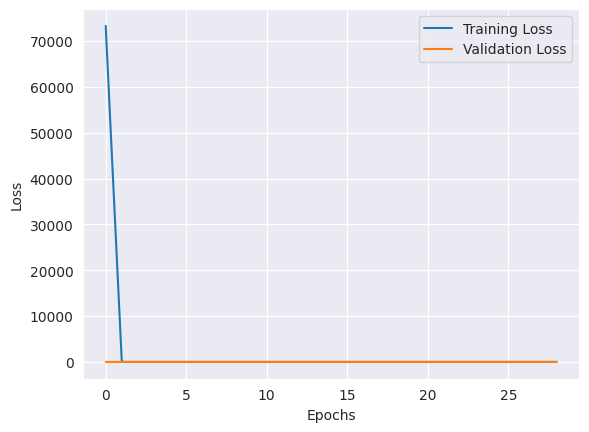

13/13 [==============================] - 0s 9ms/step
MAE: 0.06357196841607612, MSE: 0.007147589376272168
Pearson Correlation: 0.33548436812231475


In [250]:
# **4. Compilation** along with the optimizer, loss function and metrics and early stopping
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
# **5. Training with Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# **5. Training**
model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])
# plotting the training and validation loss
history = model.history.history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# getting the predicted values for the test set in an array
y_pred = model.predict(test_ds)
# getting the mae and mse between the predicted and actual values
mae = np.mean(np.abs(y_test - y_pred))
mse = np.mean((y_test - y_pred) ** 2)
print(f'MAE: {mae}, MSE: {mse}')
# getting the pearson correlation between the predicted and actual values
pearson_corr = np.corrcoef(y_test, y_pred.flatten())[0, 1]
print(f'Pearson Correlation: {pearson_corr}')